## Jdp2

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


In [2]:
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Preprocessing

In [41]:
# file directories
workingDirectory = '/home/jenhan/home/ewestin/'
binDirectory = '/home/jenhan/bin/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'
genomes = ['hg38','mm10']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirPath= workingDirectory + '/rna_tagDirectories/'
idrDirectory = workingDirectory + '/idr/'


os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
# if not os.path.isfile("nameMapping.tsv"):
nameMappingFile = open("nameMapping.tsv", "w")
for f in os.listdir(tagDirPath):
    if not 'DS' in f and not 'tmp' in f:
        rootName = f

    nameMappingFile.write(rootName + '\t' + rootName + '\n')
nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip().split('-')[0]
    treatment = metaDataTokens[3].strip()
    owner = metaDataTokens[4].strip()
    date = metaDataTokens[5].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = '-'.join([x for x in t.split('-')][:-1])
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["originalName"])) # {newName:originalName}

### read in log files ###

# create data frame summarizing mapping quality logs
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
# from tagInfo.txt
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []

# for logFile in os.listdir(logFilePath):
#     with open(logFilePath + '/' + logFile) as f:
#         data = f.readlines()
#     rootName = logFile
#     for gen in genomes:
#         rootName = rootName.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
#     totalReads = int(data[5].split()[5])
#     uniquelyMappedReads = int(data[8].split()[5])
#     multiMappedReads = int(data[23].split()[8])
#     unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads
# #     pbc = float(data[-1].split()[-1])

#     _originalNames.append(rootName)
#     _totalReads.append(totalReads)
#     _unmappedReads.append(unmappedReads)
#     _uniquelyMappedReads.append(uniquelyMappedReads)
#     _multiMappedReads.append(multiMappedReads)
for tagdir in os.listdir(tagDirPath):
    if 'RNA' in tagdir:
        with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
            data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
mappingStats_frame = pd.DataFrame([_originalNames,
#                                    _totalReads, 
#                                    _unpairedReads, 
#                                    _unmappedReads, 
#                                    _uniquelyMappedReads, 
#                                    _multiMappedReads,
                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['originalName',
#                               'totalReads', 
#                               'unpairedReads', 
#                               'unmappedReads', 
#                               'uniquelyMappedReads', 
#                               'multiMappedReads',
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

# calculate fractions from read counts
# mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
# mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']


summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')

# summary_frame = metadata_frame
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics.tsv', sep='\t', index=False)

In [42]:
mappingStats_frame

,originalName,fragmentLengthEstimate,peakSizeEstimate,tagsPerBP,averageTagsPerPosition,averageTagLength,averageFragmentGCcontent
0,C57Bl6_ThioMac_RNA_siJdp2-Veh_GJF_14-06-17,174,174,0.000548,1.1,48.636,0.424
1,C57Bl6_ThioMac_RNA_siCtrl-Veh_GJF_14-06-17,157,157,0.002408,1.396,49.881,0.447
2,C57Bl6_ThioMac_RNA_siCtrl-KLA-6h_GJF_15-02-06,75,75,0.006269,9.101,49.895,-1
3,C57Bl6_ThioMac_RNA_siJdp2-KLA-1h_GJF_14-06-17,112,112,0.000649,1.13,48.593,0.415
4,C57Bl6_ThioMac_RNA_siCtrl-KLA-6h_GFEW_15-10-30,75,75,0.010555,6.147,50.509,0.516
5,C57Bl6_ThioMac_RNA_siJdp2-KLA-6h_GJF_15-02-06,75,75,0.00789,3.613,49.917,-1
6,C57Bl6_ThioMac_RNA_siCtrl-KLA-1h_GJF_14-06-17,167,167,0.00429,1.027,49.945,0.426
7,C57Bl6_ThioMac_RNA_siCtrl-Veh_GJF_15-02-06,75,75,0.006631,5.919,49.904,-1
8,C57Bl6_ThioMac_RNA_siJdp2-KLA-6h_GFEW_15-10-30,75,75,0.009629,5.915,50.532,0.512
9,C57Bl6_ThioMac_RNA_siJdp2-Veh_GJF_15-02-06,75,75,0.005167,3.614,49.919,-1


In [44]:
summary_frame

strain      treatment owner  \
C57Bl6 siCtrl      C57Bl6     siCtrl-Veh   GJF   
       siCtrl      C57Bl6     siCtrl-Veh   GJF   
       siCtrl      C57Bl6     siCtrl-Veh  GFEW   
       siCtrl      C57Bl6     siCtrl-Veh  GFEW   
       siCtrl      C57Bl6     siCtrl-Veh  GFEW   
       siCtrl-KLA  C57Bl6  siCtrl-KLA-6h   GJF   
       siCtrl-KLA  C57Bl6  siCtrl-KLA-6h  GFEW   
       siCtrl-KLA  C57Bl6  siCtrl-KLA-1h   GJF   
       siJdp2      C57Bl6     siJdp2-Veh   GJF   
       siJdp2      C57Bl6     siJdp2-Veh   GJF   
       siJdp2      C57Bl6     siJdp2-Veh   GJF   
       siJdp2-KLA  C57Bl6  siJdp2-KLA-1h   GJF   
       siJdp2-KLA  C57Bl6  siJdp2-KLA-6h   GJF   
       siJdp2-KLA  C57Bl6  siJdp2-KLA-6h  GFEW   

                                                     originalName  \
C57Bl6 siCtrl          C57Bl6_ThioMac_RNA_siCtrl-Veh_GJF_14-06-17   
       siCtrl          C57Bl6_ThioMac_RNA_siCtrl-Veh_GJF_15-02-06   
       siCtrl         C57Bl6_ThioMac_RNA_siCtrl-Veh_GFEW_15-10-19   
       siCtrl         C57Bl6_ThioMac_RNA_siCtrl-Veh_GFEW_15-10-19   
       siCtrl         C57Bl6_ThioMac_RNA_siCtrl-Veh_GFEW_15-10-19   
       siCtrl-KLA   C57Bl6_ThioMac_RNA_siCtrl-KLA-6h_GJF_15-02-06   
       siCtrl-KLA  C57Bl6_ThioMac_RNA_siCtrl-KLA-6h_GFEW_15-10-30   
       siCtrl-KLA   C57Bl6_ThioMac_RNA_siCtrl-KLA-1h_GJF_14-06-17   
       siJdp2          C57Bl6_ThioMac_RNA_siJdp2-Veh_GJF_14-06-17   
       siJdp2          C57Bl6_ThioMac_RNA_siJdp2-Veh_GJF_15-02-06   
       siJdp2          C57Bl6_ThioMac_RNA_siJdp2-Veh_GJF_15-02-06   
       siJdp2-KLA   C57Bl6_ThioMac_RNA_siJdp2-KLA-1h_GJF_14-06-17   
       siJdp2-KLA   C57Bl6_ThioMac_RNA_siJdp2-KLA-6h_GJF_15-02-06   
       siJdp2-KLA  C57Bl6_ThioMac_RNA_siJdp2-KLA-6h_GFEW_15-10-30   

                                                       sampleName  \
C57Bl6 siCtrl          C57Bl6_ThioMac_RNA_siCtrl-Veh_GJF_14-06-17   
       siCtrl          C57Bl6_ThioMac_RNA_siCtrl-Veh_GJF_15-02-06   
       siCtrl         C57Bl6_ThioMac_RNA_siCtrl-Veh_GFEW_15-10-19   
       siCtrl         C57Bl6_ThioMac_RNA_siCtrl-Veh_GFEW_15-10-19   
       siCtrl         C57Bl6_ThioMac_RNA_siCtrl-Veh_GFEW_15-10-19   
       siCtrl-KLA   C57Bl6_ThioMac_RNA_siCtrl-KLA-6h_GJF_15-02-06   
       siCtrl-KLA  C57Bl6_ThioMac_RNA_siCtrl-KLA-6h_GFEW_15-10-30   
       siCtrl-KLA   C57Bl6_ThioMac_RNA_siCtrl-KLA-1h_GJF_14-06-17   
       siJdp2          C57Bl6_ThioMac_RNA_siJdp2-Veh_GJF_14-06-17   
       siJdp2          C57Bl6_ThioMac_RNA_siJdp2-Veh_GJF_15-02-06   
       siJdp2          C57Bl6_ThioMac_RNA_siJdp2-Veh_GJF_15-02-06   
       siJdp2-KLA   C57Bl6_ThioMac_RNA_siJdp2-KLA-1h_GJF_14-06-17   
       siJdp2-KLA   C57Bl6_ThioMac_RNA_siJdp2-KLA-6h_GJF_15-02-06   
       siJdp2-KLA  C57Bl6_ThioMac_RNA_siJdp2-KLA-6h_GFEW_15-10-30   

                  simpleTreatment fragmentLengthEstimate peakSizeEstimate  \
C57Bl6 siCtrl              siCtrl                    157              157   
       siCtrl              siCtrl                     75               75   
       siCtrl              siCtrl                     75               75   
       siCtrl              siCtrl                     75               75   
       siCtrl              siCtrl                     75               75   
       siCtrl-KLA      siCtrl-KLA                     75               75   
       siCtrl-KLA      siCtrl-KLA                     75               75   
       siCtrl-KLA      siCtrl-KLA                    167              167   
       siJdp2              siJdp2                    174              174   
       siJdp2              siJdp2                     75               75   
       siJdp2              siJdp2                     75               75   
       siJdp2-KLA      siJdp2-KLA                    112              112   
       siJdp2-KLA      siJdp2-KLA                     75               75   
       siJdp2-KLA      siJdp2-KLA                     75               75   

                  tagsPerBP averageTagsP

## Mapping Quality Control

### Plot Distributions of Mapping Statistics

In [46]:
summary_frame['averageTagsPerPosition']

C57Bl6  siCtrl        1.396
        siCtrl        5.919
        siCtrl        7.707
        siCtrl        7.707
        siCtrl        7.707
        siCtrl-KLA    9.101
        siCtrl-KLA    6.147
        siCtrl-KLA    1.027
        siJdp2          1.1
        siJdp2        3.614
        siJdp2        3.614
        siJdp2-KLA     1.13
        siJdp2-KLA    3.613
        siJdp2-KLA    5.915
Name: averageTagsPerPosition, dtype: object

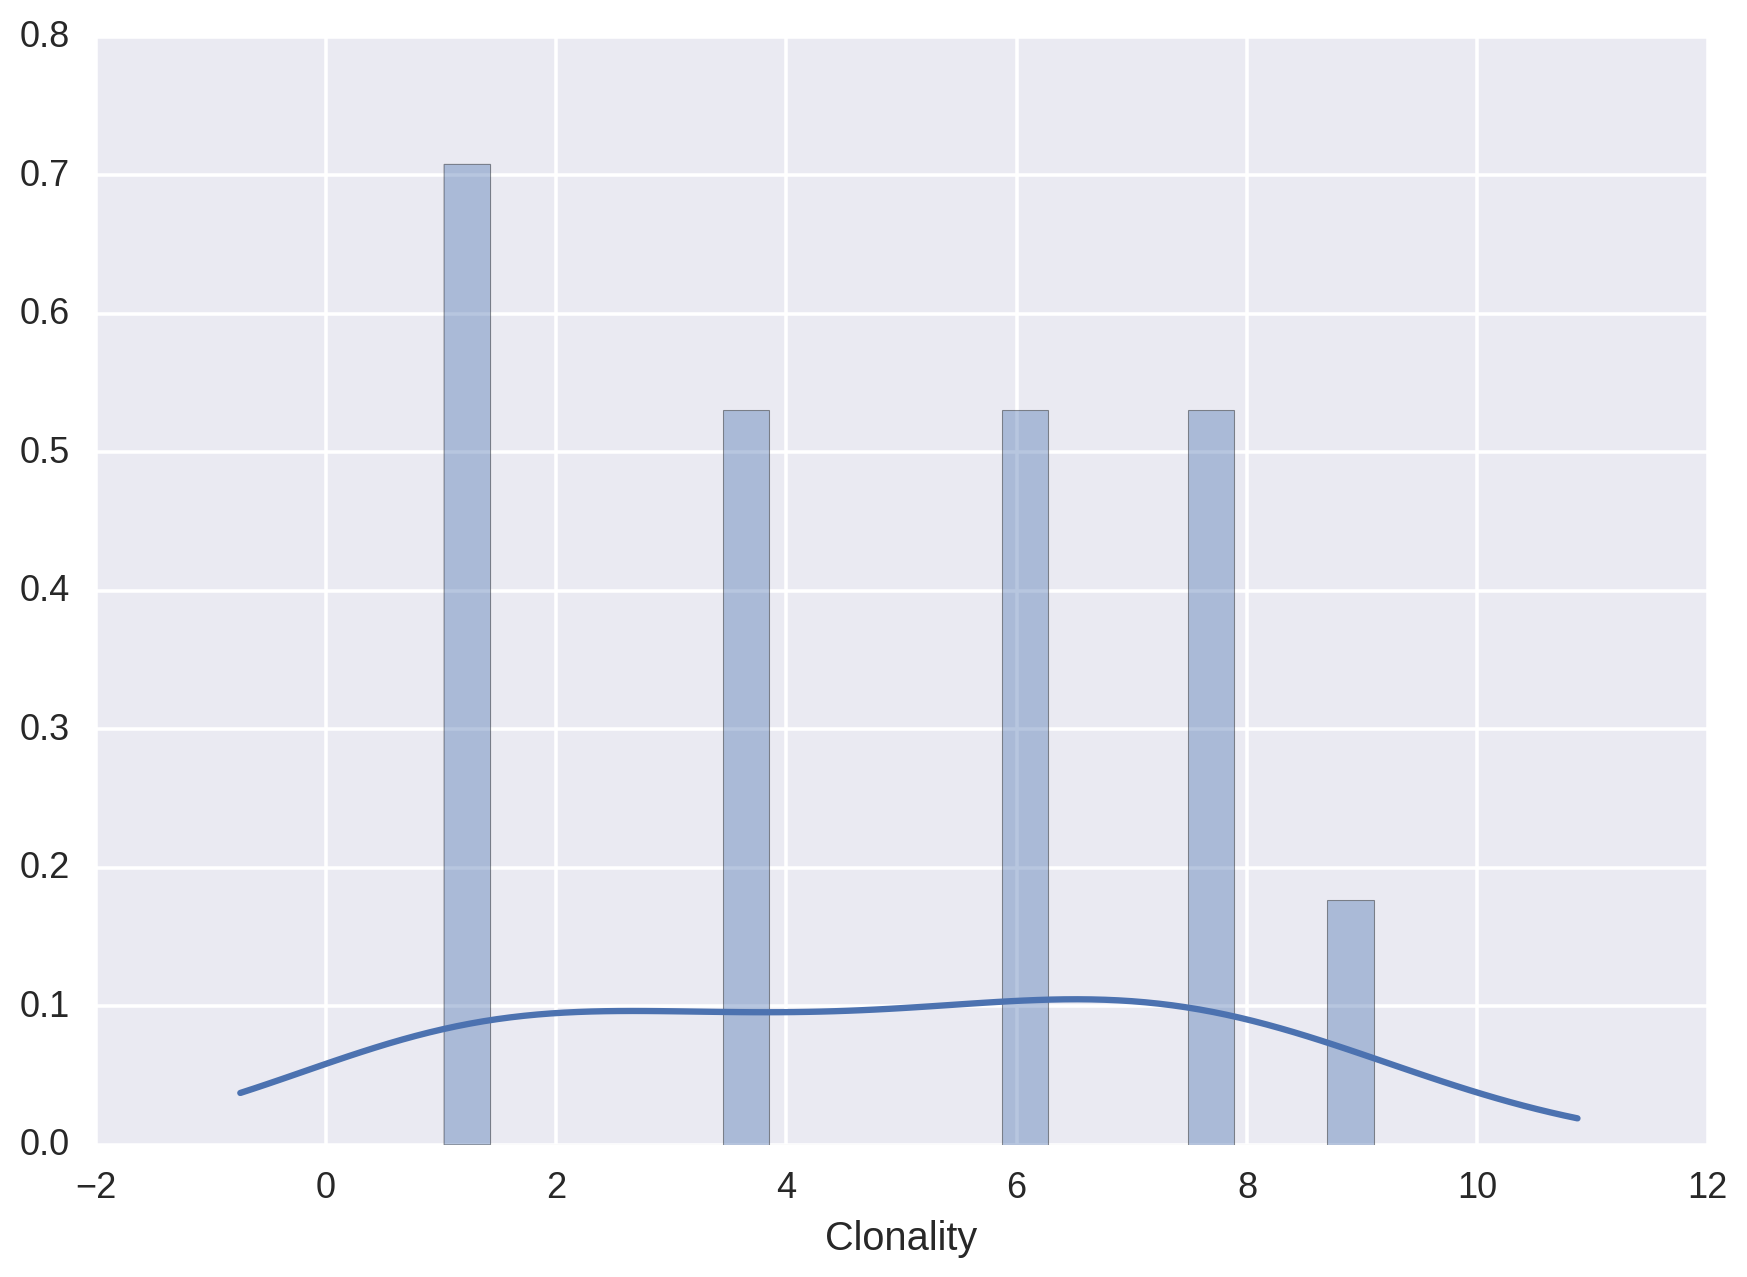

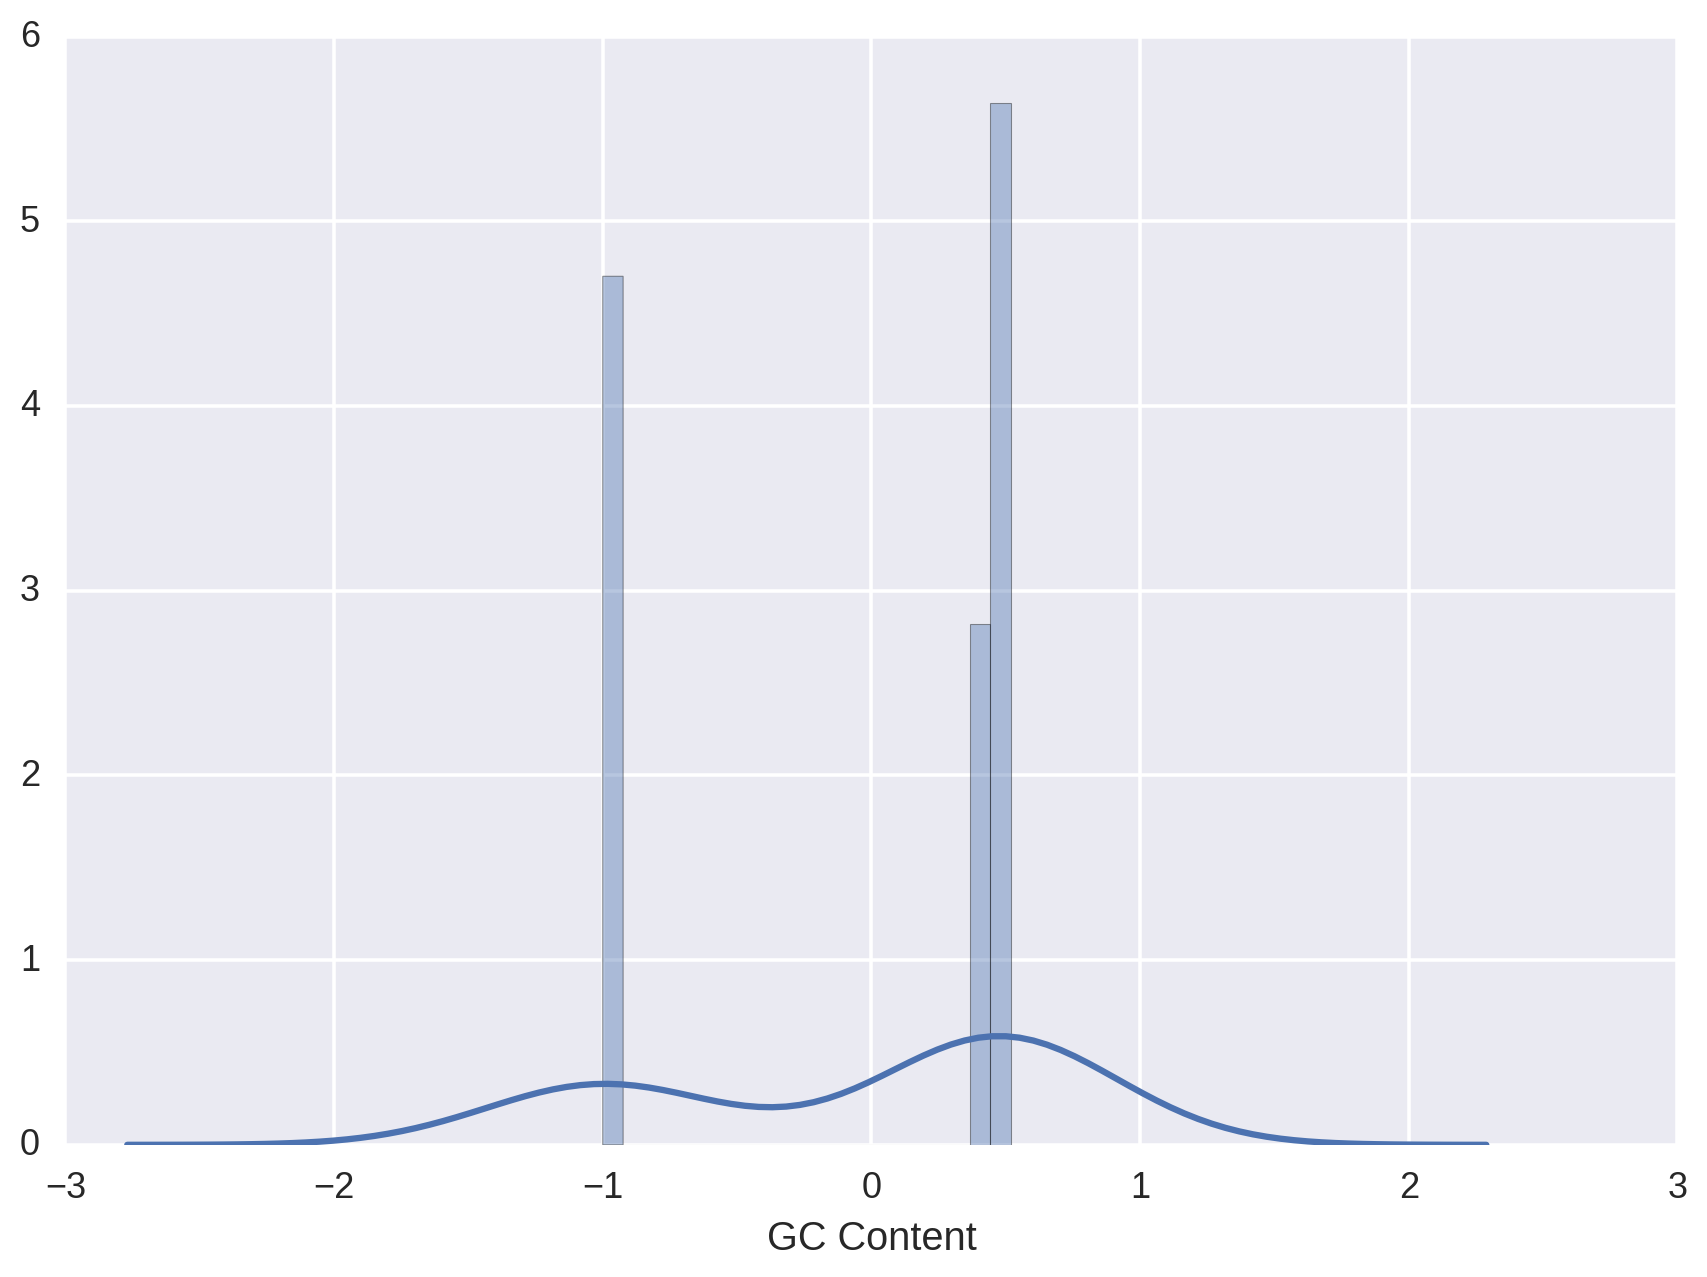

In [47]:
# plot distribution of uniquely mapped reads
# sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
# plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
# plt.xlabel('Uniquely Mapped Reads Fraction')
# plt.ylabel('Frequency')
# plt.show()

# # Distribution of Uniquely Mapped Reads per Sample
# sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False)
# plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
# plt.xlabel('Total Reads')
# plt.ylabel('Frequency')
# plt.show()

# plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
# plt.xlabel('totalReads')
# plt.ylabel('uniquelyMappedReads')
# plt.show()

sns.distplot(summary_frame['averageTagsPerPosition'], bins=20)
plt.xlabel('Clonality')
plt.show()

sns.distplot(summary_frame['averageFragmentGCcontent'], bins=20)
plt.xlabel('GC Content')
# plt.xlim([0.25,0.75])
plt.show()



### Filter Samples According to Mapping Quality

In [80]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.5
uniquelyMappedReadThreshold = 9000000
pbcThreshold=0.0
gcThreshold=0.10
clonalityThreshold = 3.0
# spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

filtered_summary_frame = filtered_summary_frame[np.abs(filtered_summary_frame['averageFragmentGCcontent'] - 0.5) <=gcThreshold]

filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['averageTagsPerPosition'] <= clonalityThreshold]


# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
# simpleTreatmentCombos = filtered_summary_frame["strain"].values + '_' +filtered_summary_frame["simpleTreatment"].values
# for simpleNameRoot in simpleTreatmentCombos:
#     if not simpleNameRoot in factorTreatment_count_dict:
#         factorTreatment_count_dict[simpleNameRoot] = 1
#     else:
#         factorTreatment_count_dict[simpleNameRoot] += 1
#     simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot]))
#     print(simplifiedName)
#     simplifiedNames.append(simplifiedName)
simplifiedNames = [x.split('_')[2] for x in filtered_summary_frame['originalName'].values]

filtered_summary_frame["simplifiedName"] = simplifiedNames
sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 

filtered_summary_frame.to_csv('filtered_qc_metrics.tsv', sep='\t', index=False)

KeyError: 'uniquelyMappedFraction'

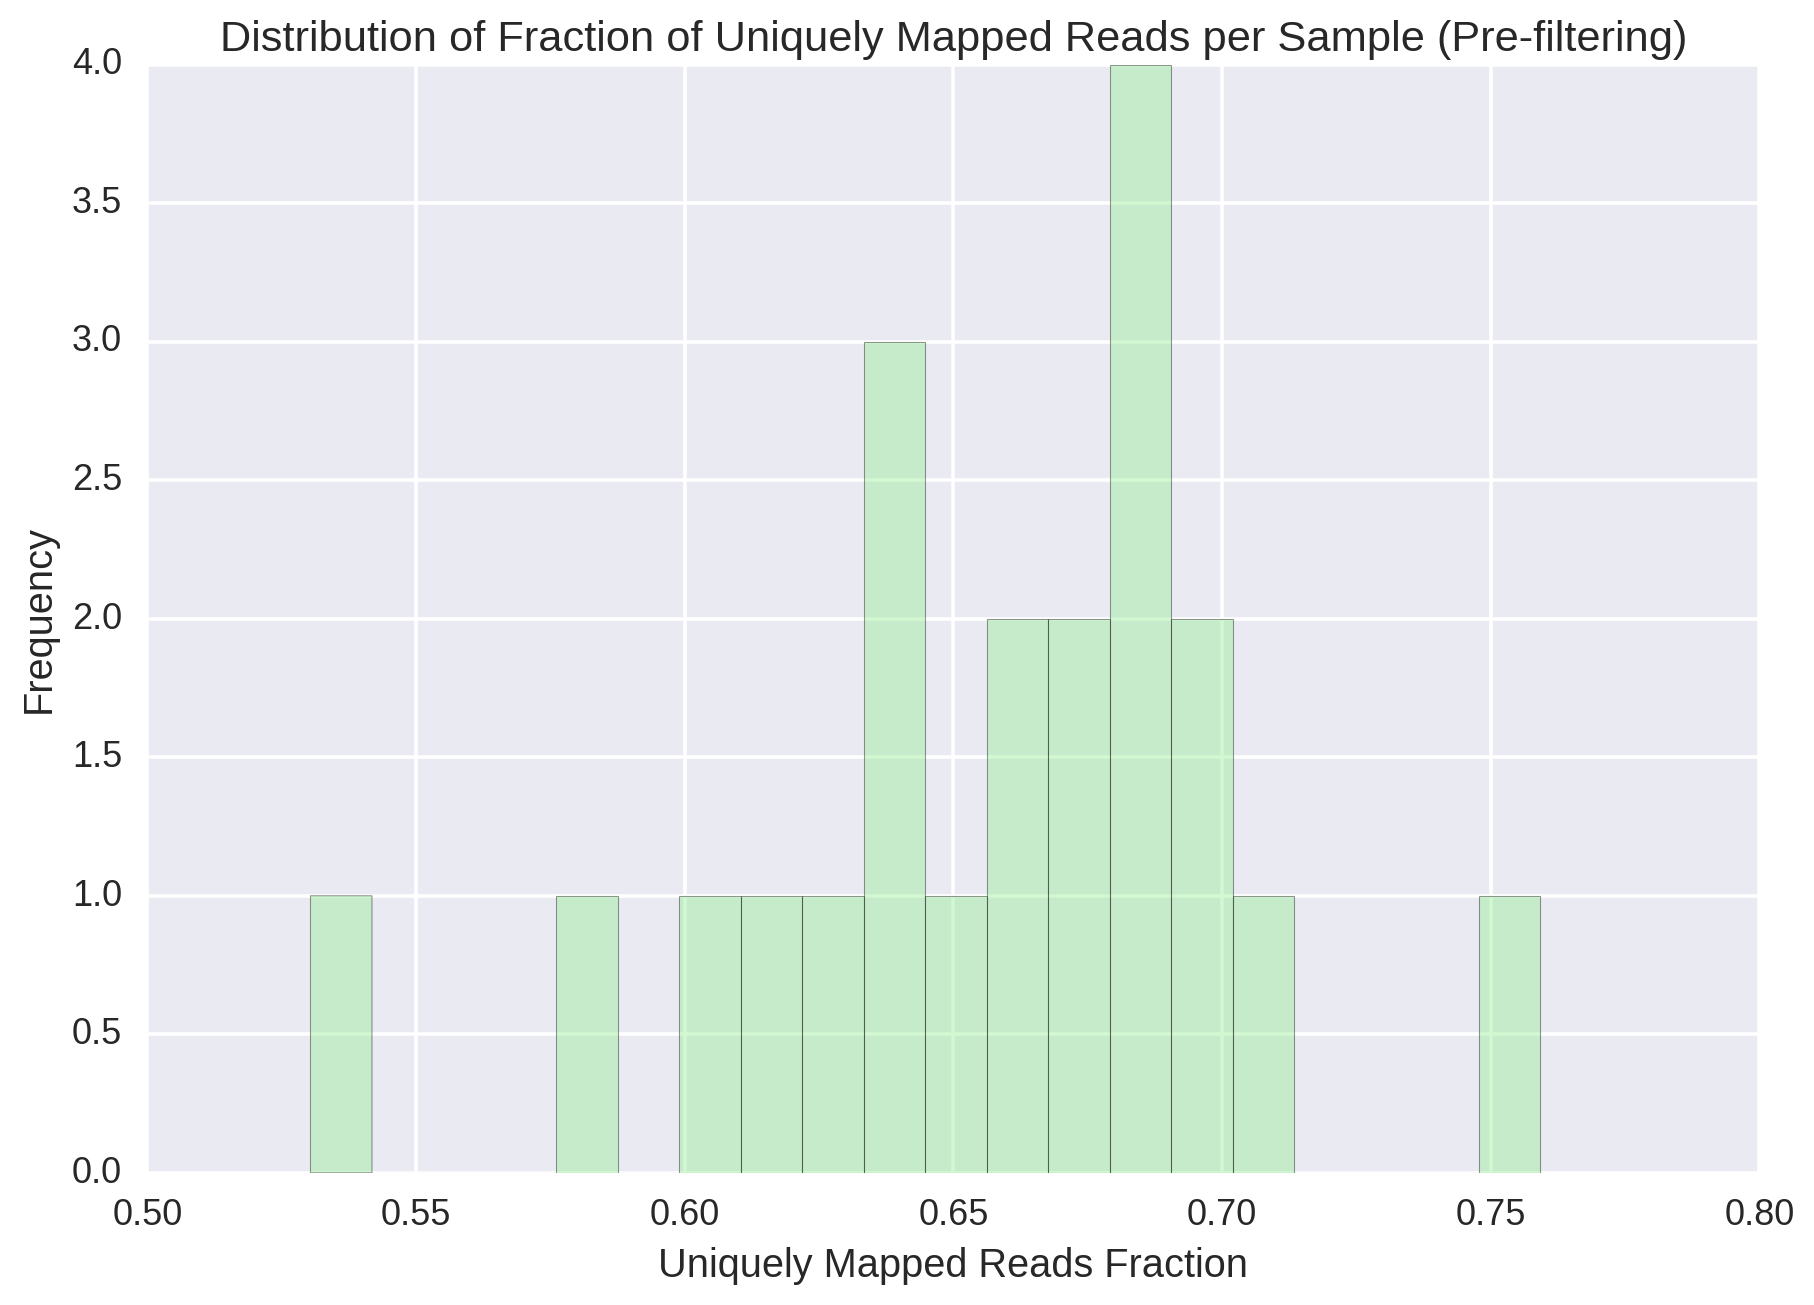

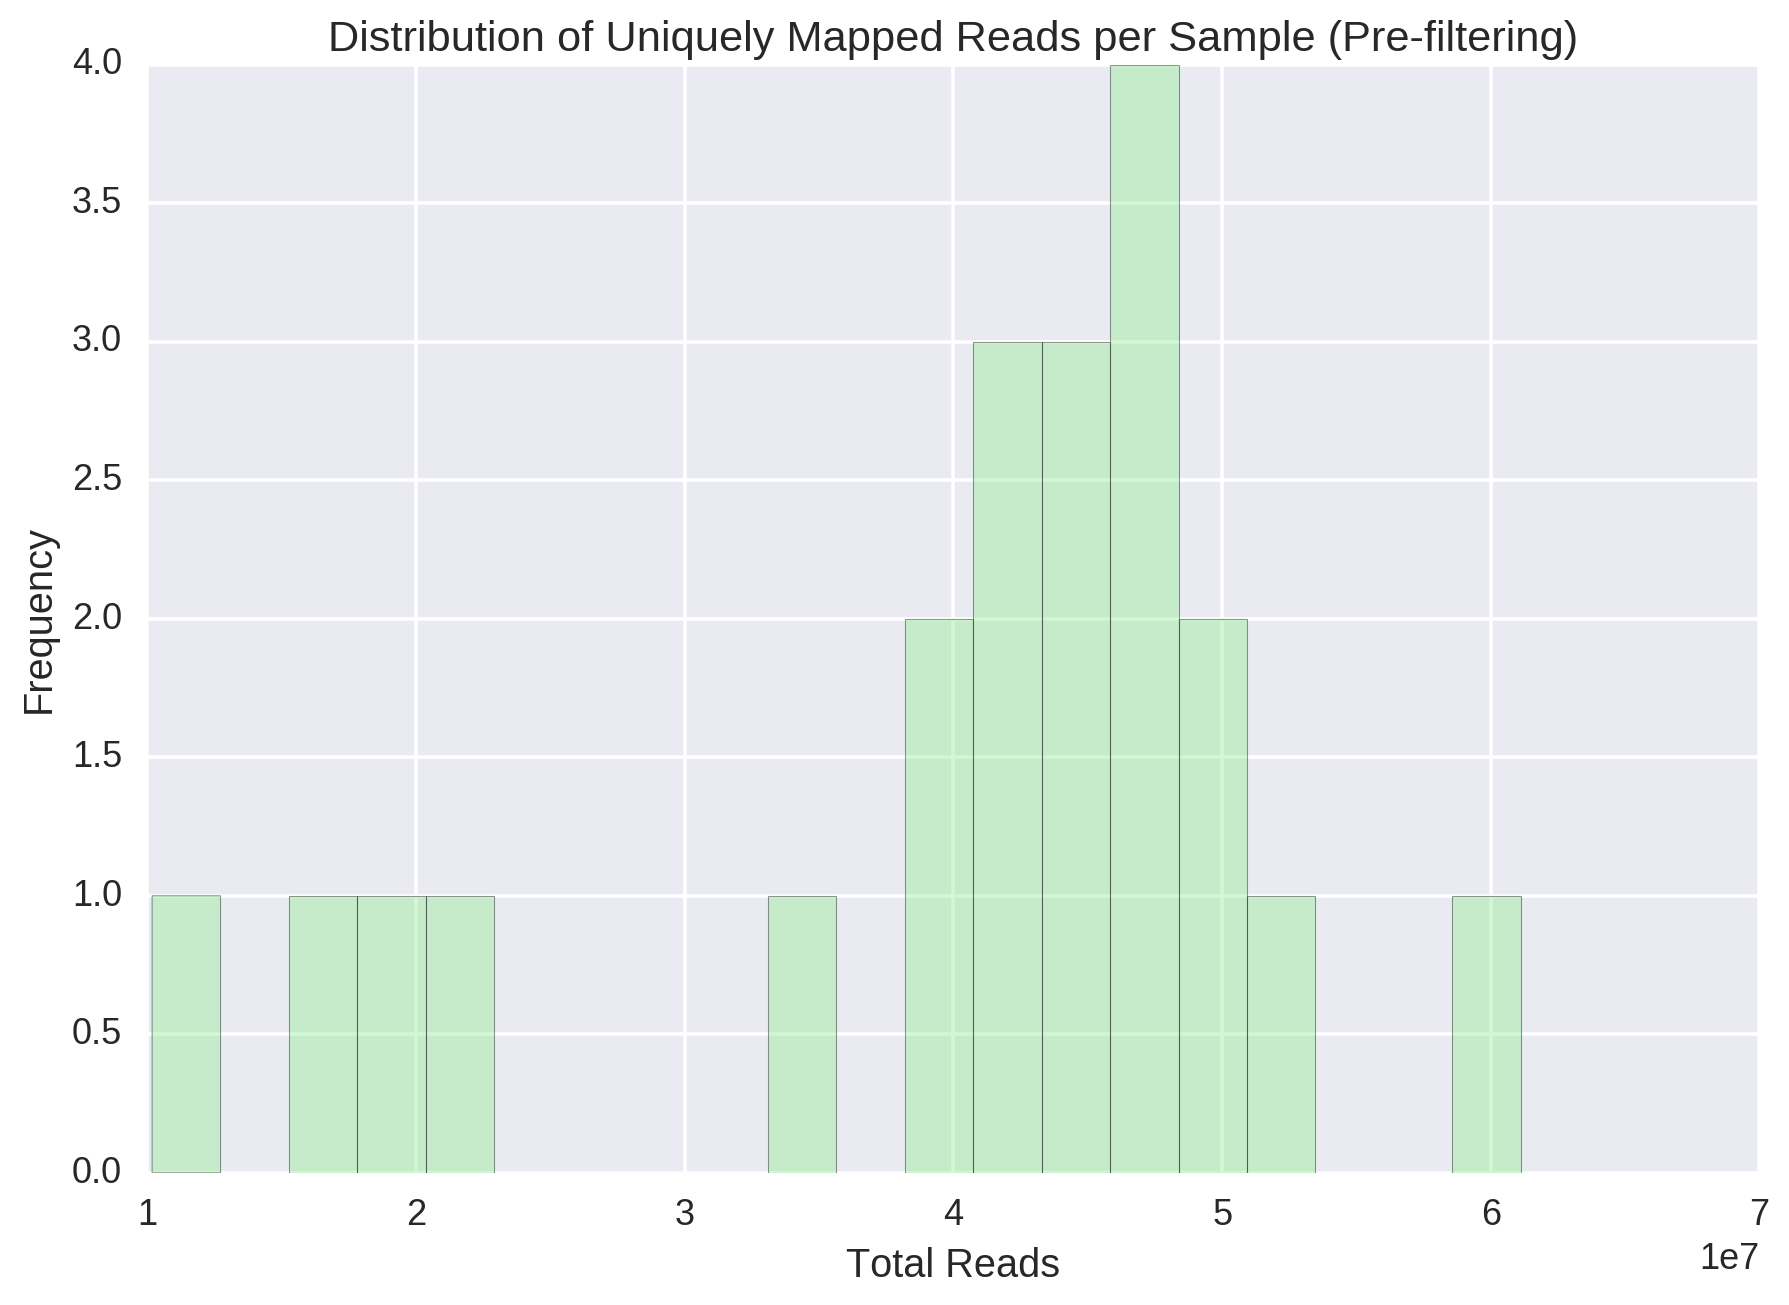

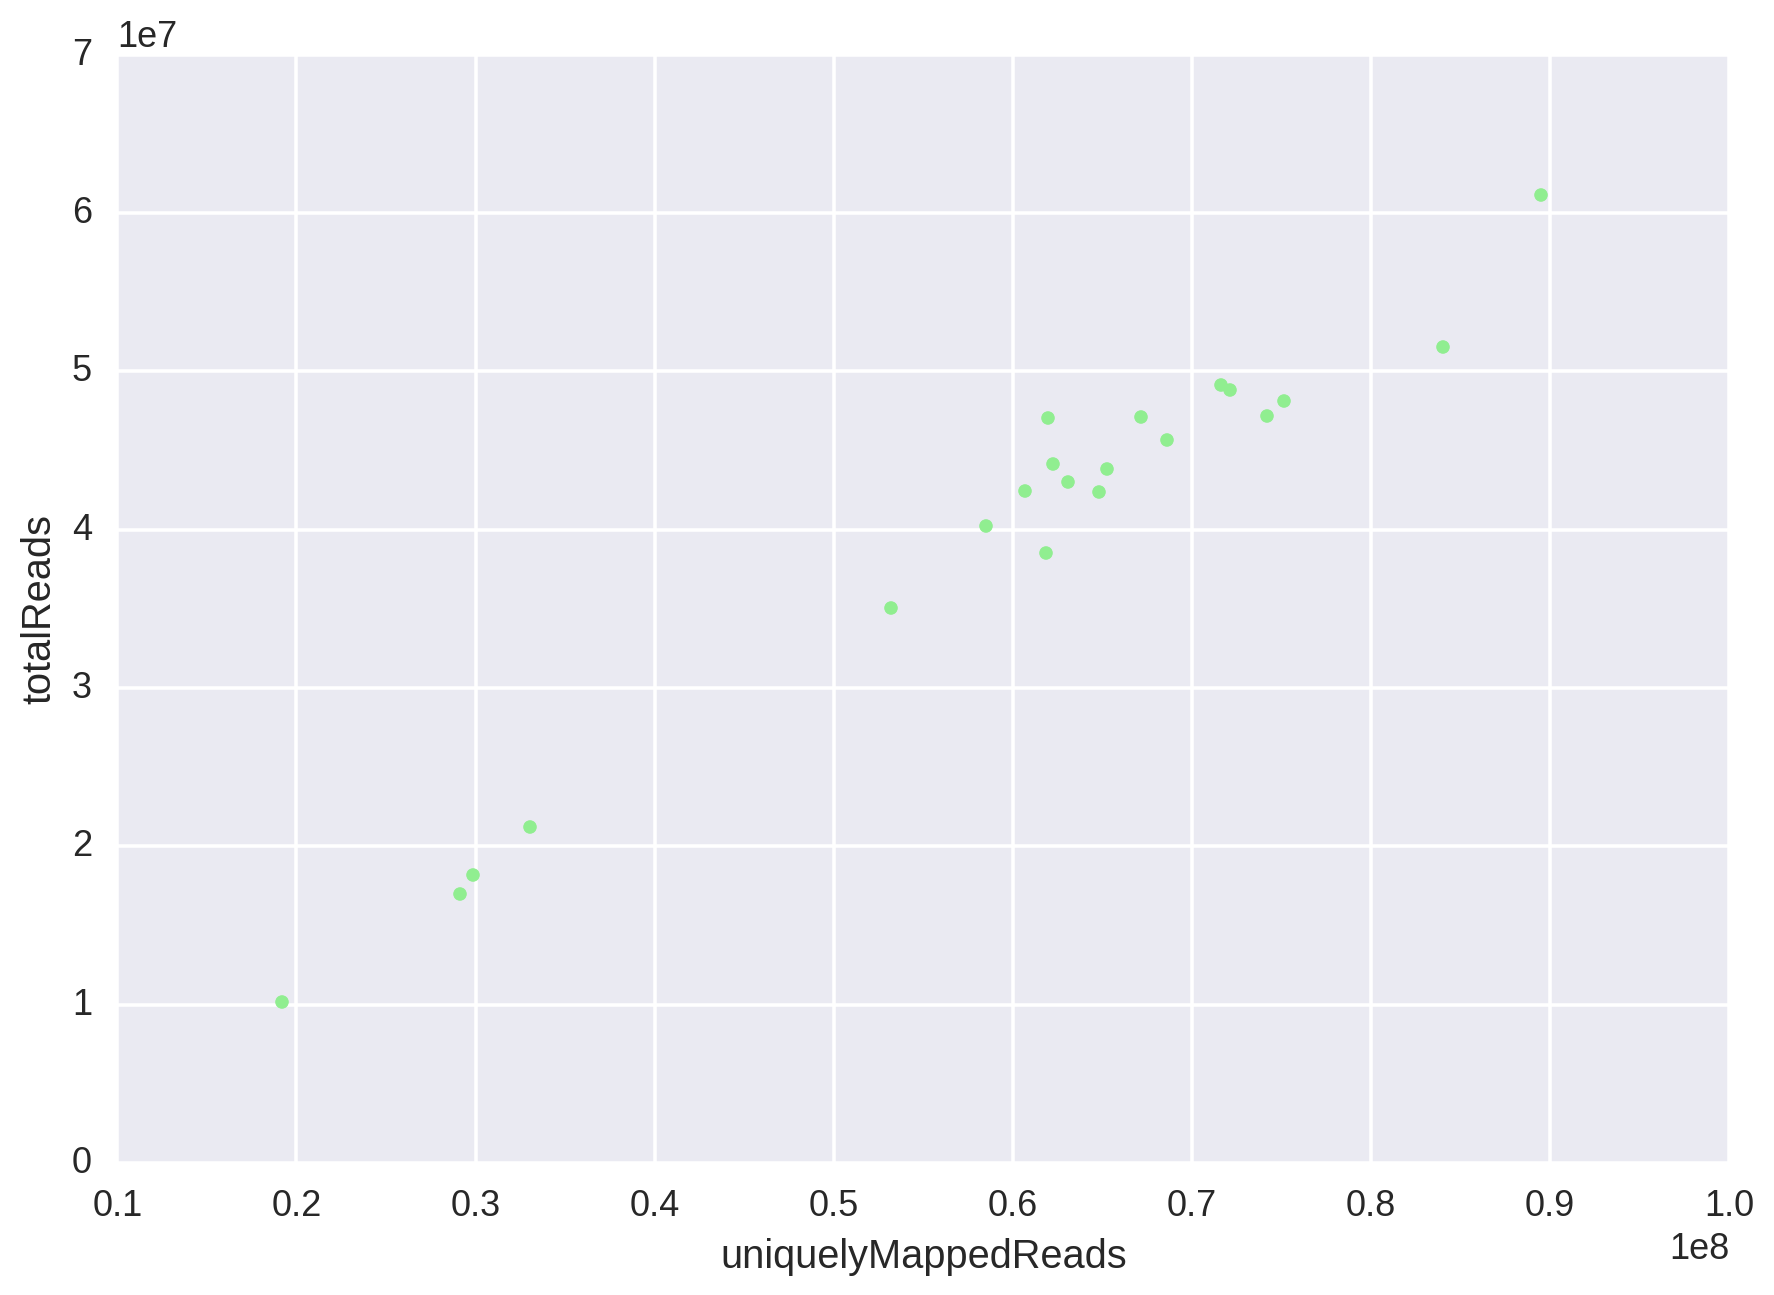

In [5]:
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color='lightgreen')
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(filtered_summary_frame['totalReads'], y=filtered_summary_frame['uniquelyMappedReads'], color='lightgreen')
plt.ylabel('totalReads')
plt.xlabel('uniquelyMappedReads')
plt.show()






## Calculate Tag Counts and RPKM

In [216]:
# %%capture
filteredTagDirectories = ' '.join([tagDirectory +x for x in filtered_summary_frame['originalName']])
!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/rpkm.tsv
!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -noadj -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/raw.tsv
!analyzeRepeats.pl rna hg38 -count exons -condenseGenes -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/normed.tsv

!echo "analyzeRepeats.pl rna hg38 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/rpkm.tsv"
!echo "analyzeRepeats.pl rna hg38 -count exons -condenseGenes -noadj -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/raw.tsv &"
!echo "analyzeRepeats.pl rna hg38 -count exons -condenseGenes -d $filteredTagDirectories >/home/jenhan/analysis/pd_analysis/normed.tsv &"

analyzeRepeats.pl rna hg38 -count exons -condenseGenes -rpkm -d /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-49_JS_14-02-26 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-22_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-27_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-34_JS_14-02-26 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-17_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-48_JS_14-02-26 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-20_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-26_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-30_JS_14-02-26 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_PD-13_JS_13-05-15 /home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_PD-10_JS_13-05-15 /home/jenhan/analysis/

In [95]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]

# read in tag counts
reads_frame = pd.read_csv("normed.tsv",sep="\t")
columns = reads_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
reads_frame.columns = columns  
reads_frame['gene'] = [x.split("|")[0] for x in reads_frame['Annotation/Divergence']]
columns = list(reads_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
reads_frame = reads_frame[columns]

raw_frame = pd.read_csv("raw.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "reads" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))


# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame['originalName'].values]]
# columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
columns = [x.split('_')[2] for x in filtered_rpkm_frame.columns.values]
filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
# filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 10.0]
to_write_frame = filtered_rpkm_frame.copy()
to_write_frame.index = [refseq_gene_mapping[x] for x in to_write_frame.index.values]
to_write_frame.to_csv('filtered_rpkm.tsv', sep='\t')
# create frame that's easier to use with factor plots
pivoting_frame = filtered_rpkm_frame.transpose()
_refseq = []
_gene = []
_rpkm = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]
for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq].upper()
    for rpkm in pivoting_frame[refseq].values:
        _rpkm.append(rpkm)
        _refseq.append(refseq)
        _gene.append(gene)
filtered_rpkm_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'rpkm': _rpkm,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
del pivoting_frame
        
filtered_rpkm_plottingFrame_log = filtered_rpkm_plottingFrame.copy()
filtered_rpkm_plottingFrame_log['rpkm'] = np.log2(filtered_rpkm_plottingFrame.rpkm)



## Run IDR

In [229]:
# %%capture
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv /home/jenhan/analysis/pd_analysis//idr/ Control Control Control Control Control Control Control Control Control PD PD PD PD PD PD PD PD PD PD PD PD
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Output files will be written to: /home/jenhan/analysis/pd_analysis//idr/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-49_JS_14-02-26 reads FPKM 	 Control
/home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-22_JS_13-05-15 reads FPKM 	 Control
/home/jenhan/analysis/pd_analysis//tag_directories/Human_RNA_Control-27_JS_13-05-15 reads FPKM 	 Control
/home/jenhan/analysis/pd_analysis//tag_directo

## Calcuate Differential Expression with EdgeR

In [224]:
# %%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['simpleTreatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x] for x in samples])
! getDiffExpression.pl raw.tsv $conditions > homer_diffExpresion.tsv


	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
Loading required package: limma


In [57]:
diffExpression_frame = pd.read_csv('diffExpression.tsv',sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0] for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

In [104]:
np.sum(diffExpression_frame['Control vs. PD PValue'] < 0.05)


1350

## Tag Scatter Plots

In [11]:
idr_rpkm_frame = pd.read_csv('idr/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
#         columns[i] = originalName_simpleName_dict[columns[i].split("/")[-1].split()[0]]
        columns[i] =columns[i].split("/")[-1].split()[0].split('_')[2]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = [x.upper() for x in idr_rpkm_frame['gene'].values]
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

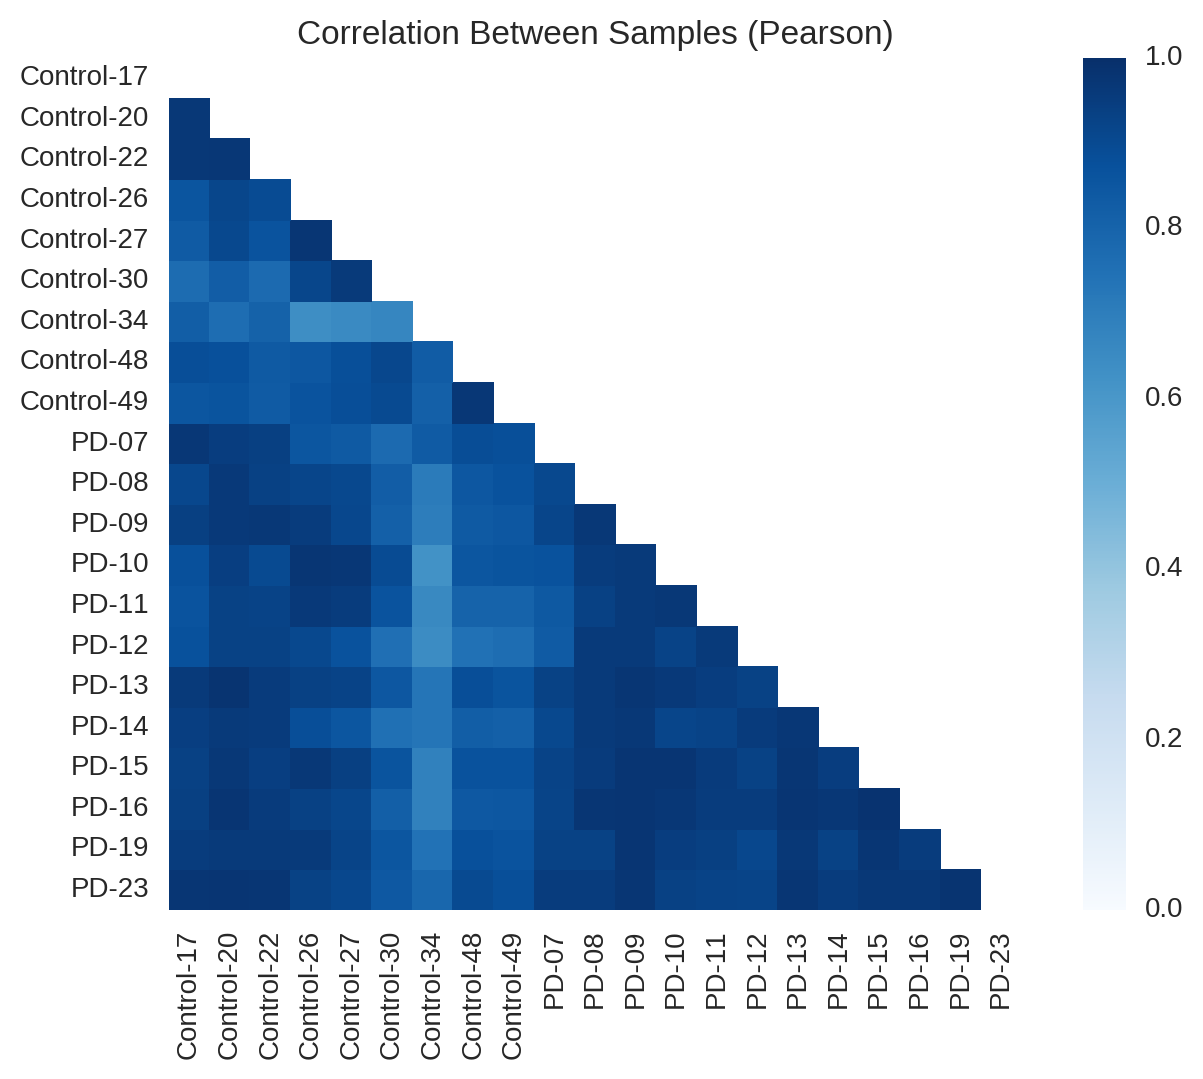

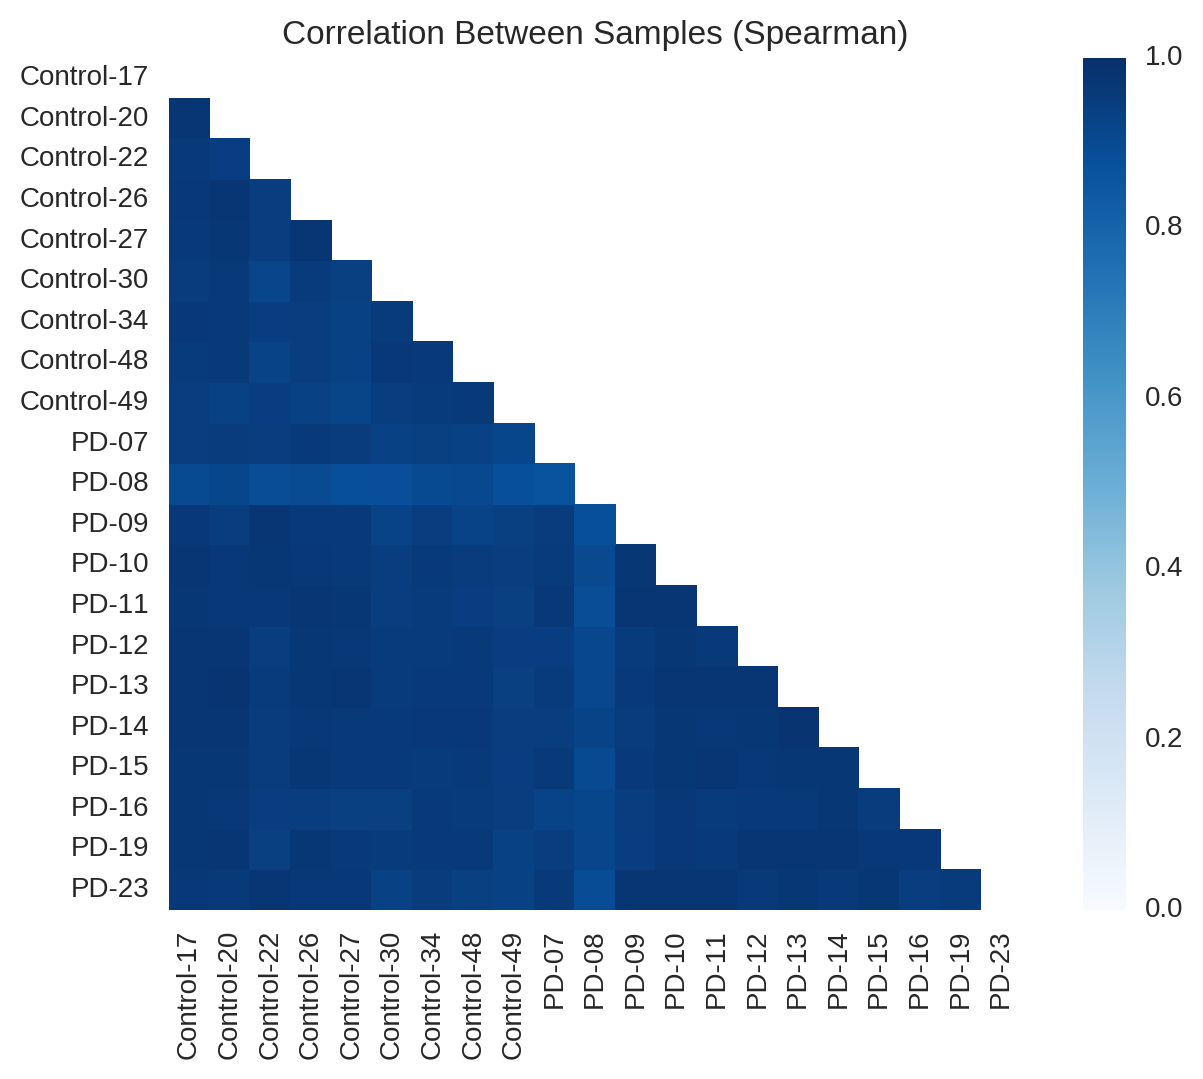

In [483]:
### cluster samples according to correlation
samples = sorted(filtered_rpkm_frame.columns.values)

labels = samples

spearman_matrix = np.zeros((len(samples), len(samples)))
pearson_matrix = np.zeros((len(samples), len(samples)))
# for i in range(len(samples)):
#     spearman_matrix[i][i]=1.0
#     pearson_matrix[i][i]=1.0

for i in range(len(samples) - 1):
    for j in range(i+1, len(samples)):
        values_1 = filtered_rpkm_frame[samples[i]].values
        values_2 = filtered_rpkm_frame[samples[j]].values
        pearson, pearson_pval = scipy.stats.pearsonr(values_1,values_2)
        spearman, spearman_pval = scipy.stats.spearmanr(values_1,values_2)
        pearson_matrix[i][j] = pearson
        pearson_matrix[j][i] = pearson
        
        spearman_matrix[i][j] = spearman
        spearman_matrix[j][i] = spearman
        
spearman_matrix = pd.DataFrame(spearman_matrix, columns=samples, index=samples)
pearson_matrix = pd.DataFrame(pearson_matrix, columns=samples, index=samples)


mask = np.zeros_like(spearman_matrix)
mask[np.triu_indices_from(mask)] = True


cg = sns.heatmap(pearson_matrix, mask = mask, cmap='Blues', square=True, vmax=1.0)
plt.title('Correlation Between Samples (Pearson)')
plt.savefig('pearson.pdf', bbox_inches='tight')
plt.show()

cg = sns.heatmap(spearman_matrix , mask = mask, cmap='Blues', square=True, vmax=1.0)
plt.title('Correlation Between Samples (Spearman)')
plt.savefig('spearman.pdf',bbox_inches='tight')
plt.show()



In [61]:
diffExpression_frame.head()

,refseq,gene,siCtrl_KLA vs. siCtrl_Veh logFC,siCtrl_KLA vs. siCtrl_Veh logCPM,siCtrl_KLA vs. siCtrl_Veh PValue,siCtrl_KLA vs. siCtrl_Veh FDR,siCtrl_KLA vs. siJdp2_KLA logFC,siCtrl_KLA vs. siJdp2_KLA logCPM,siCtrl_KLA vs. siJdp2_KLA PValue,siCtrl_KLA vs. siJdp2_KLA FDR,...,siCtrl_Veh vs. siJdp2_KLA PValue,siCtrl_Veh vs. siJdp2_KLA FDR,siCtrl_Veh vs. siJdp2_Veh logFC,siCtrl_Veh vs. siJdp2_Veh logCPM,siCtrl_Veh vs. siJdp2_Veh PValue,siCtrl_Veh vs. siJdp2_Veh FDR,siJdp2_KLA vs. siJdp2_Veh logFC,siJdp2_KLA vs. siJdp2_Veh logCPM,siJdp2_KLA vs. siJdp2_Veh PValue,siJdp2_KLA vs. siJdp2_Veh FDR
NR_040532,NR_040532,Gm10804,-3.901730,-3.922780,1.000000,1.000000,-3.121267,-3.292690,1.000000,1,...,1.000000,1.000000,0.000000,-3.883616,1.000000,1,0.000000,-3.105456,1.000000,1.000000
NM_177150,NM_177150,Cenpt,-0.930307,3.585112,0.050819,0.252501,0.164738,3.867342,0.736760,1,...,0.025873,0.150707,-0.217768,3.198677,0.660569,1,-1.294735,3.682482,0.008757,0.053712
NM_027961,NM_027961,Wfdc3,0.000000,-4.264720,1.000000,1.000000,0.000000,-3.613424,1.000000,1,...,1.000000,1.000000,0.000000,-3.883616,1.000000,1,0.000000,-3.105456,1.000000,1.000000
NM_009363,NM_009363,Tff2,0.000000,-4.264720,1.000000,1.000000,4.698644,-2.802357,0.268293,1,...,0.143505,0.516611,0.000000,-3.883616,1.000000,1,-4.430811,-2.310916,0.268293,0.701807
NM_010800,NM_010800,Bhlha15,0.000000,-4.264720,1.000000,1.000000,3.220725,-3.290204,1.000000,1,...,1.000000,1.000000,4.312595,-3.531195,0.512195,1,0.432523,-2.518740,1.000000,1.000000


In [67]:
p_threshold = 0.05
treatment_genes_up_dict = {}
treatment_genes_down_dict = {}
for col in diffExpression_frame.columns:
    if 'PValue' in col:
        fc_col = col.replace('PValue', 'logFC')
        up_genes = diffExpression_frame[(diffExpression_frame[col] < p_threshold) & (diffExpression_frame[fc_col] > 0)]['gene'].values
        down_genes = diffExpression_frame[(diffExpression_frame[col] < p_threshold) & (diffExpression_frame[fc_col] < 0)]['gene'].values
        treatment = ' '.join(col.split()[:-1])
        treatment_genes_down_dict[treatment] = set(down_genes)
        treatment_genes_up_dict[treatment] = set(up_genes)



In [69]:
from matplotlib_venn import venn2, venn3

In [70]:
treatment_genes_down_dict.keys()

dict_keys(['siCtrl_KLA vs. siCtrl_Veh', 'siCtrl_KLA vs. siJdp2_KLA', 'siJdp2_KLA vs. siJdp2_Veh', 'siCtrl_KLA vs. siJdp2_Veh', 'siCtrl_Veh vs. siJdp2_Veh', 'siCtrl_Veh vs. siJdp2_KLA'])

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


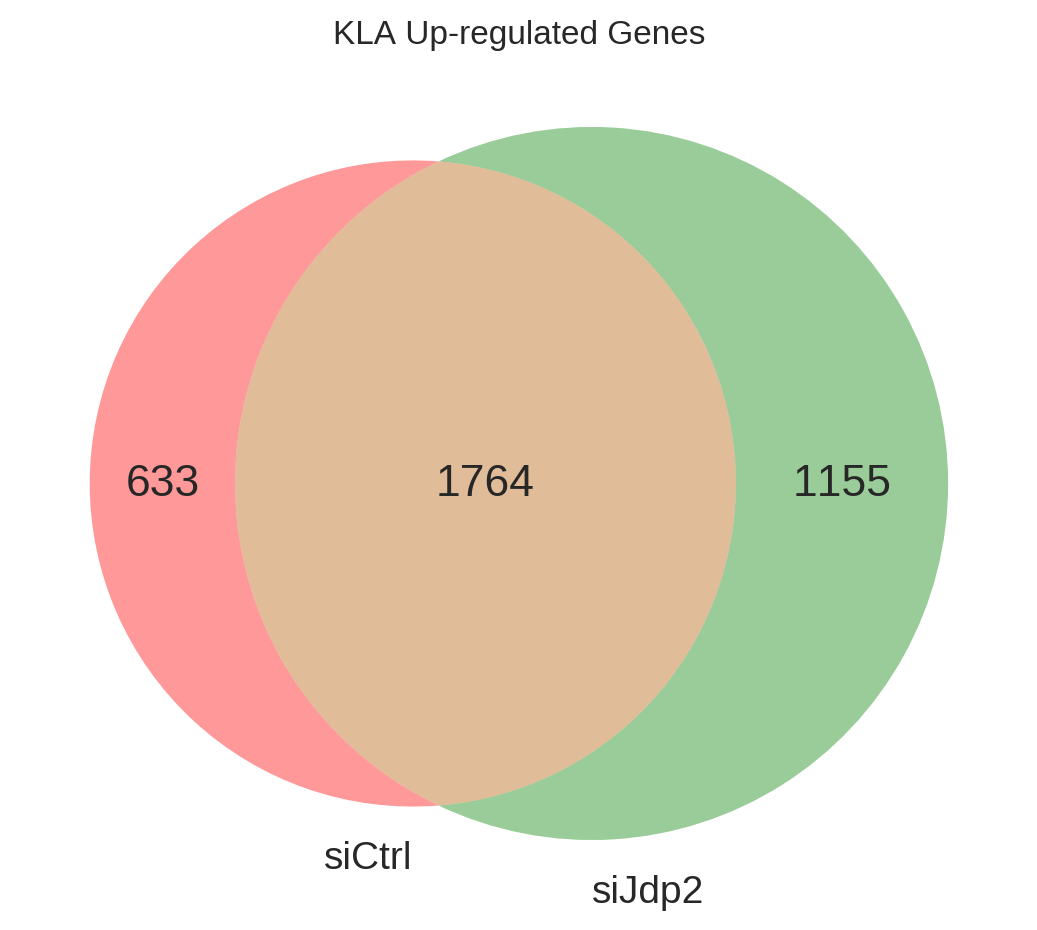

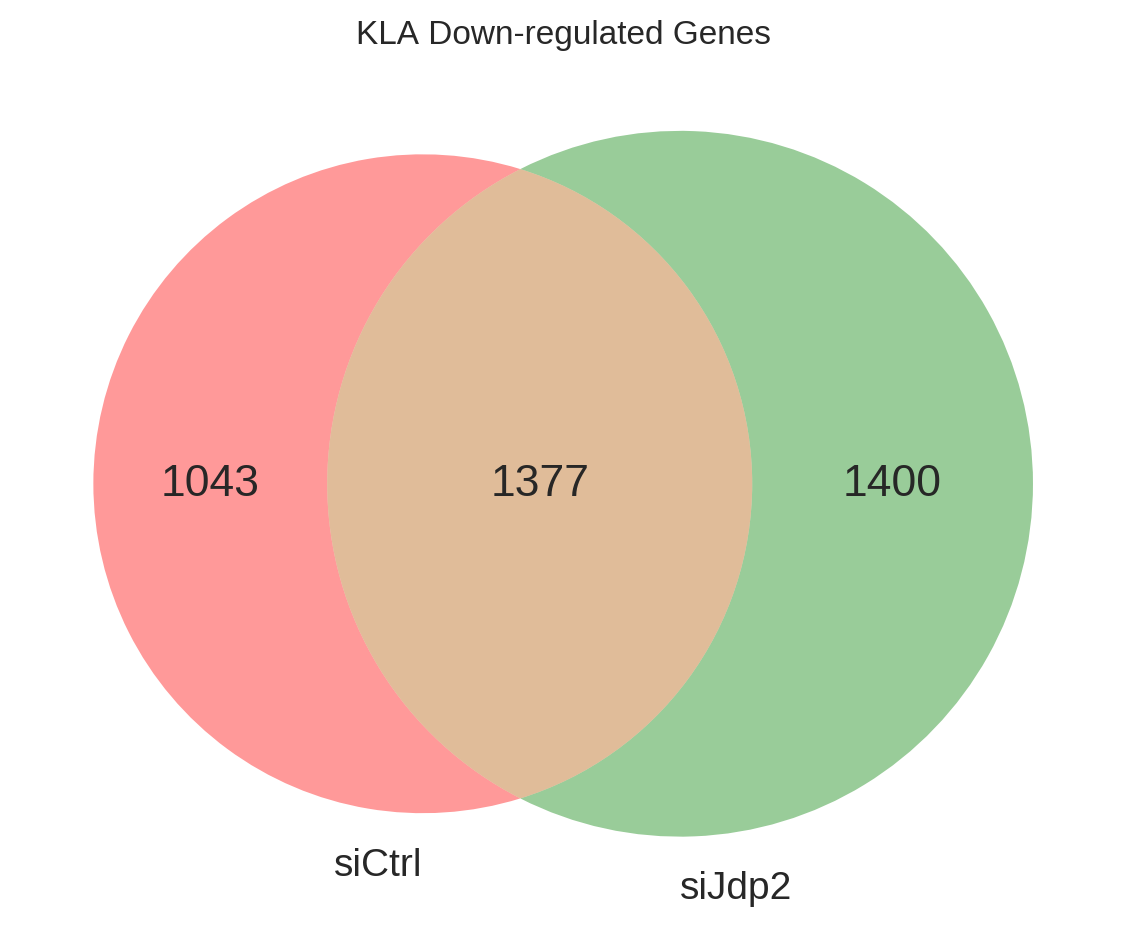

In [87]:
### KLA Response ###
out = venn2([treatment_genes_down_dict['siCtrl_KLA vs. siCtrl_Veh'], treatment_genes_down_dict['siJdp2_KLA vs. siJdp2_Veh']],
     set_labels=['siCtrl', 'siJdp2'])
for text in out.set_labels:
    text.set_fontsize(14)
for text in out.subset_labels:
    text.set_fontsize(16)    
plt.title('KLA Up-regulated Genes')
plt.show()
out = venn2([treatment_genes_up_dict['siCtrl_KLA vs. siCtrl_Veh'], treatment_genes_up_dict['siJdp2_KLA vs. siJdp2_Veh']],
     set_labels=['siCtrl', 'siJdp2'])
for text in out.set_labels:
    text.set_fontsize(14)
for text in out.subset_labels:
    text.set_fontsize(16)
plt.title('KLA Down-regulated Genes')

In [70]:
treatment_genes_down_dict.keys()

dict_keys(['siCtrl_KLA vs. siCtrl_Veh', 'siCtrl_KLA vs. siJdp2_KLA', 'siJdp2_KLA vs. siJdp2_Veh', 'siCtrl_KLA vs. siJdp2_Veh', 'siCtrl_Veh vs. siJdp2_Veh', 'siCtrl_Veh vs. siJdp2_KLA'])

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


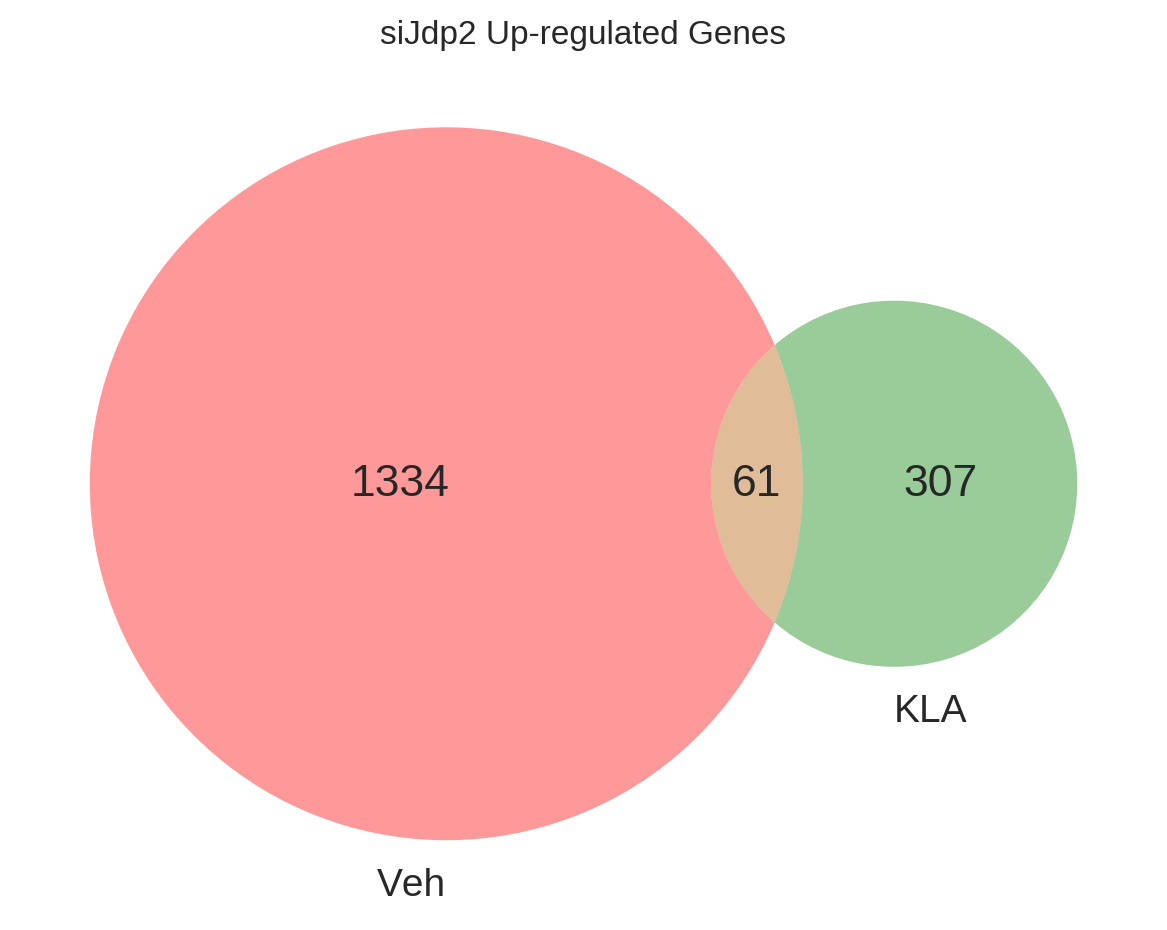

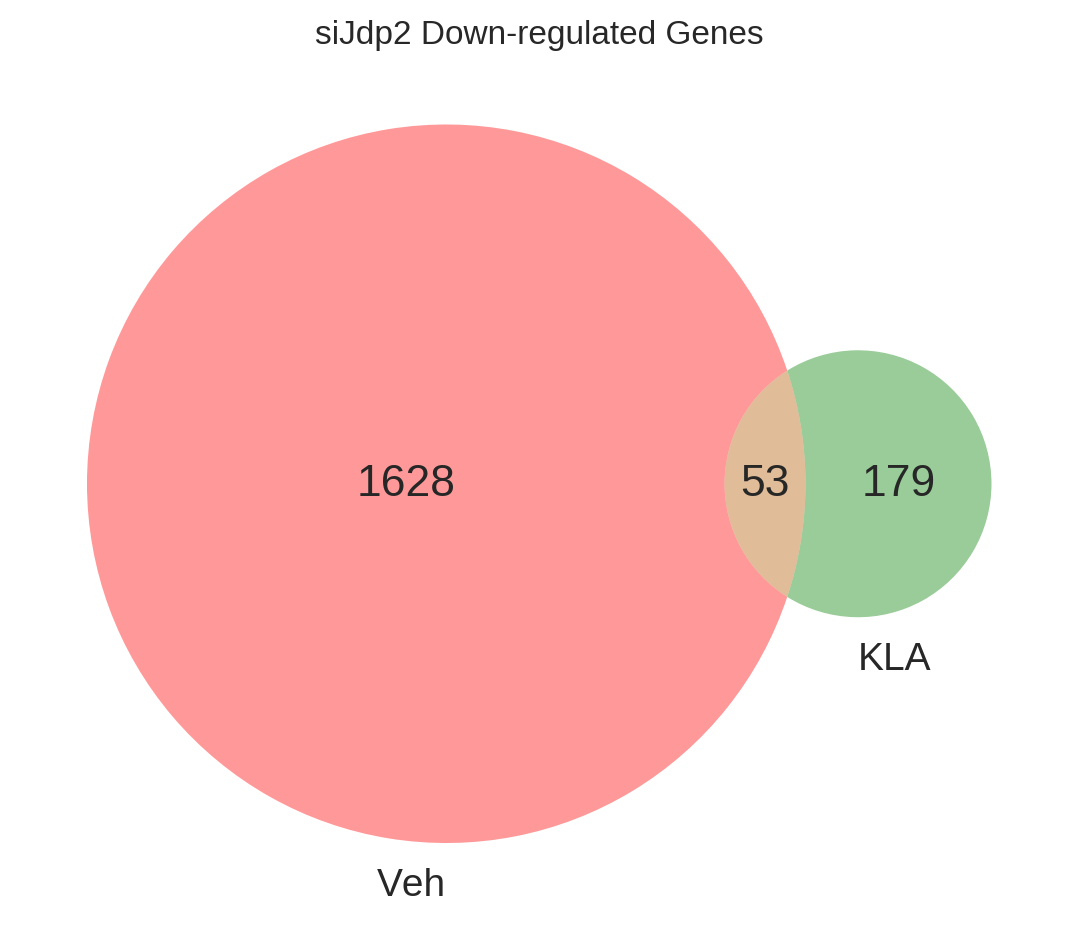

In [88]:
### knockdown effect
out=venn2([treatment_genes_up_dict['siCtrl_Veh vs. siJdp2_Veh'], treatment_genes_up_dict['siCtrl_KLA vs. siJdp2_KLA']],
     set_labels=['Veh', 'KLA'])
for text in out.set_labels:
    text.set_fontsize(14)
for text in out.subset_labels:
    text.set_fontsize(16)
plt.title('siJdp2 Up-regulated Genes')
plt.show()
out=venn2([treatment_genes_down_dict['siCtrl_Veh vs. siJdp2_Veh'], treatment_genes_down_dict['siCtrl_KLA vs. siJdp2_KLA']],
     set_labels=['Veh', 'KLA'])
for text in out.set_labels:
    text.set_fontsize(14)
for text in out.subset_labels:
    text.set_fontsize(16)
plt.title('siJdp2 Down-regulated Genes')

In [78]:
### knockdown effect
# up genes
for g in treatment_genes_up_dict['siCtrl_Veh vs. siJdp2_Veh'].intersection(treatment_genes_up_dict['siCtrl_KLA vs. siJdp2_KLA']):
    print(g)



Mir17hg
Hvcn1
2610203C22Rik
Mettl21a
Cgref1
Prrx1
Ptprd
Srxn1
Tdrkh
D10Bwg1379e
Tfb1m
Uchl1
A530064D06Rik
Ddit4l
Il1b
Pira2
Zwint
Gpr141
Bdh2
Trim29
Siglecg
Kbtbd8
Prelid2
Igf2bp3
Ass1
AA414768
Aph1b
Bnip3
H3f3a
S1pr3
Cst3
Slc7a11
Slc16a3
Map6
Jade3
2210404O09Rik
Fkbp1b
Gm20748
C630043F03Rik
B3gnt5
Slc16a6
Rab3b
Dnmt3aos
Adam23
Gm5424
Dsel
Rgs16
LOC100503496
Kbtbd3
Alox5ap
Nap1l2
S100a16
Havcr2
Il12rb2
Psmb7
Clec1b
Cthrc1
Egln3
Gm2115
Itih5
Pira6


In [79]:
# down genes
for g in treatment_genes_down_dict['siCtrl_Veh vs. siJdp2_Veh'].intersection(treatment_genes_down_dict['siCtrl_KLA vs. siJdp2_KLA']):
    print(g)



Atp6v0a1
Gm5464
Chd3
Jdp2
Sprr1a
Cideb
Fosb
Zfp30
Spred3
Nrg2
Fam102a
A2m
Spry2
Cdk18
Lppr2
Stab2
Gm19897
Plxnb1
Slc25a23
F5
Tmem246
Plagl1
Cd72
Mir5132
Rab3ip
Gpr98
Gdpd2
Dgka
Dact2
Ptn
Dhrs11
Rhbdf1
Slc26a11
Gm20605
Mfsd6
Cep112
Hoxd3
Flt1
Arap3
Ifitm6
Mir7654
Apoc4
Eif2ak1
Acacb
Tcf7l1
Cdo1
Pla2g2d
Tmem109
St14
Adcy3
Sirt2
Slco4a1
Lrch4
